In [ ]:
"""
Medical RAG-based Diagnostic Reasoning System
Dataset: MIMIC-IV-Ext-Direct-1.0.0
LLM: Google Gemini API
Retrieval: FAISS + Sentence Transformers

This notebook implements a complete RAG pipeline for clinical diagnosis support.
"""

# Install required packages
!pip install -q google-generativeai sentence-transformers faiss-cpu pandas numpy tqdm rarfile streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import zipfile
import rarfile
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import re
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# HuggingFace Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Sentence Transformers for embeddings
from sentence_transformers import SentenceTransformer

# FAISS for vector search
import faiss

# For display
from IPython.display import display, Markdown, HTML

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"💻 CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
🔥 PyTorch version: 2.9.0+cu126
💻 CUDA available: True


In [ ]:
# ============================================================================
# DATASET EXTRACTION AND EXPLORATION
# ============================================================================

# Define paths
DATASET_ZIP = "/content/dataset.zip"
EXTRACT_DIR = "/content/mimic-iv-ext-direct-1.0.0"

print("📦 Extracting dataset...")
print(f"   Source: {DATASET_ZIP}")
print(f"   Target: {EXTRACT_DIR}")

# Extract the main ZIP file
if not Path(EXTRACT_DIR).exists():
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    print("✅ Dataset extracted successfully!")
else:
    print("✅ Dataset already extracted!")

# Explore directory structure
print("\n📂 Exploring dataset structure...")
print("=" * 80)

def explore_directory(path, level=0, max_level=3):
    """Recursively explore directory structure"""
    path = Path(path)
    indent = "  " * level

    if level > max_level:
        return

    if path.is_file():
        size = path.stat().st_size
        size_str = f"{size/1024:.1f}KB" if size < 1024*1024 else f"{size/(1024*1024):.1f}MB"
        print(f"{indent}📄 {path.name} ({size_str})")
    elif path.is_dir():
        print(f"{indent}📁 {path.name}/")
        try:
            items = sorted(path.iterdir(), key=lambda x: (x.is_file(), x.name))
            for item in items[:10]:  # Limit to first 10 items
                explore_directory(item, level + 1, max_level)
            if len(items) > 10:
                print(f"{indent}  ... and {len(items) - 10} more items")
        except PermissionError:
            print(f"{indent}  [Permission Denied]")

explore_directory(EXTRACT_DIR)
print("=" * 80)

📦 Extracting dataset...
   Source: /content/dataset.zip
   Target: /content/mimic-iv-ext-direct-1.0.0
✅ Dataset extracted successfully!

📂 Exploring dataset structure...
📁 mimic-iv-ext-direct-1.0.0/
  📁 mimic-iv-ext-direct-1.0.0/
    📁 Finished/
      📁 Acute Coronary Syndrome/
      📁 Adrenal Insufficiency/
      📁 Alzheimer/
      📁 Aortic Dissection/
      📁 Asthma/
      📁 Atrial Fibrillation/
      📁 COPD/
        ... and 9 more items
      📁 Cardiomyopathy/
      📁 Diabetes/
      📁 Epilepsy/
      ... and 16 more items
    📄 .DS_Store (6.0KB)
    📄 LICENSE.txt (2.3KB)
    📄 README.md (5.3KB)
    📄 SHA256SUMS.txt (0.3KB)
    📄 diagnostic_kg.rar (25.6KB)
    📄 samples.rar (1.2MB)


In [ ]:
# ============================================================================
# DETAILED DATASET ANALYSIS
# ============================================================================

# Find the actual data directories
base_path = Path(EXTRACT_DIR)

# Locate Finished directory
finished_dirs = list(base_path.rglob("Finished"))
if finished_dirs:
    FINISHED_DIR = finished_dirs[0]
    print(f"✅ Found Finished directory: {FINISHED_DIR}")
else:
    print("⚠️ Finished directory not found!")
    FINISHED_DIR = None

# Locate diagnostic_kg.rar
kg_rar_files = list(base_path.rglob("diagnostic_kg.rar"))
if kg_rar_files:
    KG_RAR_PATH = kg_rar_files[0]
    print(f"✅ Found Knowledge Graph RAR: {KG_RAR_PATH}")
else:
    print("⚠️ diagnostic_kg.rar not found!")
    KG_RAR_PATH = None

# Analyze Finished directory structure
if FINISHED_DIR:
    print("\n" + "=" * 80)
    print("📊 CLINICAL CASES ANALYSIS (Finished directory)")
    print("=" * 80)

    diagnosis_folders = [d for d in FINISHED_DIR.iterdir() if d.is_dir()]

    total_cases = 0
    diagnosis_stats = []

    for diag_dir in sorted(diagnosis_folders):
        diag_name = diag_dir.name

        # Check for subtypes
        subtype_dirs = [d for d in diag_dir.iterdir() if d.is_dir()]

        if subtype_dirs:
            # Has subtypes
            for subtype_dir in subtype_dirs:
                json_files = list(subtype_dir.glob("*.json"))
                count = len(json_files)
                total_cases += count
                diagnosis_stats.append({
                    'Diagnosis': diag_name,
                    'Subtype': subtype_dir.name,
                    'Cases': count
                })
        else:
            # Direct JSON files
            json_files = list(diag_dir.glob("*.json"))
            count = len(json_files)
            total_cases += count
            diagnosis_stats.append({
                'Diagnosis': diag_name,
                'Subtype': '-',
                'Cases': count
            })

    # Create DataFrame
    df_stats = pd.DataFrame(diagnosis_stats)

    print(f"\n📈 Total Diagnoses: {len(diagnosis_folders)}")
    print(f"📈 Total Clinical Cases: {total_cases}")
    print("\n📋 Breakdown by Diagnosis:")
    print("-" * 80)
    display(df_stats)

    # Summary by main diagnosis
    print("\n📊 Summary by Main Diagnosis:")
    print("-" * 80)
    summary = df_stats.groupby('Diagnosis')['Cases'].sum().sort_values(ascending=False)
    for diag, count in summary.items():
        print(f"  {diag:.<50} {count:>5} cases")

print("\n" + "=" * 80)

✅ Found Finished directory: /content/mimic-iv-ext-direct-1.0.0/mimic-iv-ext-direct-1.0.0/Finished
✅ Found Knowledge Graph RAR: /content/mimic-iv-ext-direct-1.0.0/mimic-iv-ext-direct-1.0.0/diagnostic_kg.rar

📊 CLINICAL CASES ANALYSIS (Finished directory)

📈 Total Diagnoses: 25
📈 Total Clinical Cases: 511

📋 Breakdown by Diagnosis:
--------------------------------------------------------------------------------


,Diagnosis,Subtype,Cases
0,Acute Coronary Syndrome,UA,22
1,Acute Coronary Syndrome,STEMI,15
2,Acute Coronary Syndrome,NSTEMI,28
3,Adrenal Insufficiency,Congenital Adrenal Hyperplasia,3
4,Adrenal Insufficiency,Primary Adrenal Insufficiency,7
5,Adrenal Insufficiency,Secondary Adrenal Insufficiency,10
6,Alzheimer,-,10
7,Aortic Dissection,Type A Aortic Dissection,5
8,Aortic Dissection,Type B Aortic Dissection,9
9,Asthma,COPD Asthma,2



📊 Summary by Main Diagnosis:
--------------------------------------------------------------------------------
  Acute Coronary Syndrome...........................    65 cases
  Heart Failure.....................................    52 cases
  Gastro-oesophageal Reflux Disease.................    41 cases
  Pulmonary Embolism................................    35 cases
  Hypertension......................................    32 cases
  Stroke............................................    28 cases
  Peptic Ulcer Disease..............................    28 cases
  Gastritis.........................................    27 cases
  Multiple Sclerosis................................    27 cases
  Pneumonia.........................................    20 cases
  Adrenal Insufficiency.............................    20 cases
  COPD..............................................    19 cases
  Aortic Dissection.................................    14 cases
  Asthma....................................

In [ ]:
# ============================================================================
# INSPECT SAMPLE CLINICAL CASES
# ============================================================================

print("🔍 INSPECTING SAMPLE CLINICAL CASES")
print("=" * 80)

def load_and_display_case(json_path: Path):
    """Load and display a clinical case"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            case_data = json.load(f)

        print(f"\n📄 Case: {json_path.name}")
        print(f"   Path: {json_path.parent.name}")
        print("-" * 80)

        # Display all keys
        print(f"\n🔑 Available Keys ({len(case_data)} total):")
        for key in case_data.keys():
            print(f"   - {key}")

        # Display input fields
        print(f"\n📝 Clinical Information:")
        for i in range(1, 7):
            key = f"input{i}"
            if key in case_data:
                value = case_data[key]
                label = {
                    'input1': 'Chief Complaint',
                    'input2': 'History',
                    'input3': 'Past History',
                    'input4': 'Physical Exam',
                    'input5': 'Laboratory Results',
                    'input6': 'Imaging'
                }.get(key, key)

                print(f"\n   [{label}]")
                preview = value[:200] if len(value) > 200 else value
                print(f"   {preview}...")

        # Display diagnostic reasoning keys
        diag_keys = [k for k in case_data.keys() if k.startswith('<Diagnosis>')]
        if diag_keys:
            print(f"\n🧠 Diagnostic Reasoning Graph:")
            print(f"   Found {len(diag_keys)} diagnostic nodes")
            for key in diag_keys[:3]:  # Show first 3
                print(f"   - {key}")

        return case_data

    except Exception as e:
        print(f"⚠️ Error loading {json_path}: {e}")
        return None

# Find and display sample cases from different diagnoses
if FINISHED_DIR:
    sample_count = 0
    max_samples = 3

    for diag_dir in FINISHED_DIR.iterdir():
        if not diag_dir.is_dir() or sample_count >= max_samples:
            break

        # Find first JSON file
        json_files = list(diag_dir.rglob("*.json"))
        if json_files:
            print(f"\n{'='*80}")
            print(f"SAMPLE {sample_count + 1}: {diag_dir.name}")
            print(f"{'='*80}")
            load_and_display_case(json_files[0])
            sample_count += 1

print("\n" + "=" * 80)

🔍 INSPECTING SAMPLE CLINICAL CASES



In [ ]:
# ============================================================================
# EXTRACT AND EXPLORE KNOWLEDGE GRAPHS
# ============================================================================

print("🧠 KNOWLEDGE GRAPH EXTRACTION AND EXPLORATION")
print("=" * 80)

# Extract diagnostic_kg.rar
if KG_RAR_PATH:
    KG_EXTRACT_DIR = base_path / "diagnostic_kg_extracted"

    if not KG_EXTRACT_DIR.exists():
        print(f"📦 Extracting {KG_RAR_PATH.name}...")
        KG_EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

        with rarfile.RarFile(KG_RAR_PATH) as rf:
            rf.extractall(KG_EXTRACT_DIR)

        print(f"✅ Extracted to: {KG_EXTRACT_DIR}")
    else:
        print(f"✅ Already extracted: {KG_EXTRACT_DIR}")

    # Find actual KG directory
    kg_json_files = list(KG_EXTRACT_DIR.rglob("*.json"))

    if kg_json_files:
        kg_dir = kg_json_files[0].parent
        print(f"\n📂 Knowledge Graph Directory: {kg_dir}")
        print(f"📊 Total KG files: {len(kg_json_files)}")

        print("\n📋 Knowledge Graph Files:")
        print("-" * 80)
        for kg_file in sorted(kg_json_files):
            size = kg_file.stat().st_size / 1024
            print(f"   📄 {kg_file.name:.<50} {size:>8.1f} KB")

        # Load and inspect sample KG
        print("\n" + "=" * 80)
        print("🔍 SAMPLE KNOWLEDGE GRAPH INSPECTION")
        print("=" * 80)

        sample_kg_file = kg_json_files[0]
        print(f"\n📄 File: {sample_kg_file.name}")

        with open(sample_kg_file, 'r', encoding='utf-8') as f:
            kg_data = json.load(f)

        print(f"\n🔑 Top-level Keys:")
        for key in kg_data.keys():
            print(f"   - {key}")

        # Explore 'knowledge' section
        if 'knowledge' in kg_data:
            print(f"\n📚 Knowledge Section:")
            knowledge = kg_data['knowledge']
            for key in knowledge.keys():
                value = knowledge[key]
                if isinstance(value, list):
                    print(f"   - {key}: {len(value)} items")
                    if value:
                        print(f"      Examples: {value[:3]}")
                elif isinstance(value, dict):
                    print(f"   - {key}: {len(value)} sub-items")
                else:
                    print(f"   - {key}: {str(value)[:100]}...")

        # Explore 'diagnostic' section
        if 'diagnostic' in kg_data:
            print(f"\n🔬 Diagnostic Section:")
            diagnostic = kg_data['diagnostic']
            print(f"   Type: {type(diagnostic)}")
            if isinstance(diagnostic, dict):
                print(f"   Keys: {list(diagnostic.keys())[:5]}")

        print("\n" + "=" * 80)
    else:
        print("⚠️ No JSON files found in extracted KG directory")
        kg_dir = None
else:
    print("⚠️ Knowledge Graph RAR file not found")
    kg_dir = None
    KG_EXTRACT_DIR = None

🧠 KNOWLEDGE GRAPH EXTRACTION AND EXPLORATION
📦 Extracting diagnostic_kg.rar...
✅ Extracted to: /content/mimic-iv-ext-direct-1.0.0/diagnostic_kg_extracted

📂 Knowledge Graph Directory: /content/mimic-iv-ext-direct-1.0.0/diagnostic_kg_extracted/Diagnosis_flowchart
📊 Total KG files: 24

📋 Knowledge Graph Files:
--------------------------------------------------------------------------------
   📄 Acute Coronary Syndrome.json......................      1.0 KB
   📄 Adrenal Insufficiency.json........................      2.5 KB
   📄 Alzheimer.json....................................      2.5 KB
   📄 Aortic Dissection.json............................      0.8 KB
   📄 Asthma.json.......................................      2.4 KB
   📄 Atrial Fibrillation.json..........................      1.0 KB
   📄 COPD.json.........................................      1.0 KB
   📄 Cardiomyopathy.json...............................      2.4 KB
   📄 Diabetes.json.....................................      3.0 

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the RAG system"""

    # Paths (dynamically set from exploration)
    BASE_DIR = base_path
    FINISHED_DIR = FINISHED_DIR
    KG_DIR = kg_dir if 'kg_dir' in locals() and kg_dir else None
    KG_EXTRACT_DIR = KG_EXTRACT_DIR if 'KG_EXTRACT_DIR' in locals() else None

    # Model Configuration
    EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # Fast and efficient for embeddings

    # LLM Options (choose based on your resources):
    # 1. "microsoft/Phi-3-mini-4k-instruct" - 3.8B, very fast, RECOMMENDED
    # 2. "mistralai/Mistral-7B-Instruct-v0.2" - 7B, excellent quality
    # 3. "TinyLlama/TinyLlama-1.1B-Chat-v1.0" - 1.1B, fastest but lower quality

    LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"  # Best balance for medical tasks

    # Retrieval Configuration
    TOP_K_RETRIEVAL = 5  # Number of documents to retrieve
    EMBEDDING_DIM = 384  # Dimension for all-MiniLM-L6-v2

    # Generation Configuration
    MAX_NEW_TOKENS = 512
    TEMPERATURE = 0.3
    TOP_P = 0.9

    # Index paths
    FAISS_INDEX_PATH = "medical_rag_faiss.index"
    METADATA_PATH = "medical_rag_metadata.json"

    # Device configuration
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    USE_8BIT = True if torch.cuda.is_available() else False  # 8-bit quantization

config = Config()

print("✅ Configuration Setup Complete!")
print("=" * 80)
print(f"📁 Base directory: {config.BASE_DIR}")
print(f"📁 Finished directory: {config.FINISHED_DIR}")
print(f"📁 Knowledge Graph directory: {config.KG_DIR}")
print(f"🤖 Embedding model: {config.EMBEDDING_MODEL}")
print(f"🧠 LLM model: {config.LLM_MODEL}")
print(f"💻 Device: {config.DEVICE}")
print(f"🔧 8-bit quantization: {config.USE_8BIT}")
print("=" * 80)

# Verify paths exist
if config.FINISHED_DIR and config.FINISHED_DIR.exists():
    print("✅ Clinical cases directory found")
else:
    print("⚠️ Clinical cases directory not found!")

if config.KG_DIR and config.KG_DIR.exists():
    print("✅ Knowledge graph directory found")
else:
    print("⚠️ Knowledge graph directory not found!")

✅ Configuration Setup Complete!
📁 Base directory: /content/mimic-iv-ext-direct-1.0.0
📁 Finished directory: /content/mimic-iv-ext-direct-1.0.0/mimic-iv-ext-direct-1.0.0/Finished
📁 Knowledge Graph directory: None
🤖 Embedding model: all-MiniLM-L6-v2
🧠 LLM model: microsoft/Phi-3-mini-4k-instruct
💻 Device: cuda
🔧 8-bit quantization: True
✅ Clinical cases directory found
⚠️ Knowledge graph directory not found!


In [ ]:
# ============================================================================
# DATA LOADING UTILITIES
# ============================================================================

def load_clinical_case(json_path: Path) -> Dict:
    """Load a single clinical case JSON file"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"⚠️ Error loading {json_path}: {e}")
        return None


def parse_clinical_case(case_data: Dict, diagnosis: str, subtype: str = None) -> Dict:
    """Parse clinical case into structured format"""
    parsed = {
        'diagnosis': diagnosis,
        'subtype': subtype,
        'chief_complaint': case_data.get('input1', ''),
        'history': case_data.get('input2', ''),
        'past_history': case_data.get('input3', ''),
        'physical_exam': case_data.get('input4', ''),
        'labs': case_data.get('input5', ''),
        'imaging': case_data.get('input6', ''),
        'reasoning_graph': {}
    }

    # Extract diagnostic reasoning graph
    for key, value in case_data.items():
        if key.startswith('<Diagnosis>'):
            parsed['reasoning_graph'][key] = value

    return parsed


def create_document_text(parsed_case: Dict) -> str:
    """Create searchable text from clinical case"""
    text_parts = [
        f"Diagnosis: {parsed_case['diagnosis']}",
    ]

    if parsed_case['subtype']:
        text_parts.append(f"Subtype: {parsed_case['subtype']}")

    text_parts.extend([
        f"Chief Complaint: {parsed_case['chief_complaint']}",
        f"History: {parsed_case['history']}",
        f"Past Medical History: {parsed_case['past_history']}",
        f"Physical Examination: {parsed_case['physical_exam']}",
        f"Laboratory Results: {parsed_case['labs']}",
        f"Imaging Findings: {parsed_case['imaging']}"
    ])

    return "\n\n".join(text_parts)


def load_all_clinical_cases(finished_dir: Path) -> List[Dict]:
    """Load all clinical cases from the Finished directory"""
    all_cases = []

    print("📚 Loading clinical cases...")

    # Iterate through diagnosis folders
    for diagnosis_dir in finished_dir.iterdir():
        if not diagnosis_dir.is_dir():
            continue

        diagnosis_name = diagnosis_dir.name
        print(f"  Loading {diagnosis_name}...")

        # Check for subtypes (e.g., NSTEMI, STEMI, UA)
        subtype_dirs = [d for d in diagnosis_dir.iterdir() if d.is_dir()]

        if subtype_dirs:
            # Has subtypes
            for subtype_dir in subtype_dirs:
                subtype_name = subtype_dir.name
                json_files = list(subtype_dir.glob("*.json"))

                for json_file in json_files:
                    case_data = load_clinical_case(json_file)
                    if case_data:
                        parsed = parse_clinical_case(case_data, diagnosis_name, subtype_name)
                        parsed['file_path'] = str(json_file)
                        all_cases.append(parsed)
        else:
            # No subtypes, JSON files directly in diagnosis folder
            json_files = list(diagnosis_dir.glob("*.json"))

            for json_file in json_files:
                case_data = load_clinical_case(json_file)
                if case_data:
                    parsed = parse_clinical_case(case_data, diagnosis_name, None)
                    parsed['file_path'] = str(json_file)
                    all_cases.append(parsed)

    print(f"✅ Loaded {len(all_cases)} clinical cases")
    return all_cases


print("✅ Data loading functions defined!")

✅ Data loading functions defined!


In [ ]:
# ============================================================================
# FIX KNOWLEDGE GRAPH DIRECTORY PATH
# ============================================================================

print("🔧 Fixing Knowledge Graph directory path...")

# The KG directory is actually in the extracted location
kg_dir = Path("/content/mimic-iv-ext-direct-1.0.0/diagnostic_kg_extracted/Diagnosis_flowchart")

if kg_dir.exists():
    config.KG_DIR = kg_dir
    print(f"✅ Knowledge Graph directory found: {kg_dir}")
    print(f"   Files: {len(list(kg_dir.glob('*.json')))} JSON files")

    # Now load knowledge graphs
    knowledge_graphs = load_knowledge_graphs(config.KG_DIR)

    # Add KG documents to our existing documents
    print("\nProcessing knowledge graphs...")
    kg_start_idx = len(documents)

    for idx, kg in enumerate(tqdm(knowledge_graphs, desc="Knowledge graphs")):
        doc_text = extract_kg_text(kg)
        documents.append(doc_text)
        metadata.append({
            'id': f"kg_{idx}",
            'type': 'knowledge_graph',
            'diagnosis': kg['diagnosis'],
            'source_file': kg['source_file']
        })

    print("\n" + "=" * 80)
    print(f"✅ UPDATED DOCUMENT COLLECTION")
    print(f"   - Clinical cases: {len(clinical_cases)}")
    print(f"   - Knowledge graphs: {len(knowledge_graphs)}")
    print(f"   - Total documents: {len(documents)}")
    print("=" * 80)

    # Display sample KG document
    if len(documents) > kg_start_idx:
        print(f"\n📄 Sample Knowledge Graph Document:")
        print("-" * 80)
        print(f"Type: {metadata[kg_start_idx]['type']}")
        print(f"Diagnosis: {metadata[kg_start_idx]['diagnosis']}")
        print(f"\nContent:\n{documents[kg_start_idx][:500]}...")
        print("-" * 80)
else:
    print(f"⚠️ Knowledge Graph directory still not found: {kg_dir}")

🔧 Fixing Knowledge Graph directory path...
✅ Knowledge Graph directory found: /content/mimic-iv-ext-direct-1.0.0/diagnostic_kg_extracted/Diagnosis_flowchart
   Files: 24 JSON files
🧠 Loading knowledge graphs...


Loading KGs:   0%|          | 0/24 [00:00<?, ?it/s]

✅ Loaded 24 knowledge graphs

Processing knowledge graphs...


Knowledge graphs:   0%|          | 0/24 [00:00<?, ?it/s]


✅ UPDATED DOCUMENT COLLECTION
   - Clinical cases: 511
   - Knowledge graphs: 24
   - Total documents: 535

📄 Sample Knowledge Graph Document:
--------------------------------------------------------------------------------
Type: knowledge_graph
Diagnosis: Upper Gastrointestinal Bleeding

Content:
Diagnosis: Upper Gastrointestinal Bleeding
Diagnostic Criteria: {"Suspected Upper Gastrointestinal Bleeding": {"Upper Gastrointestinal Bleeding": []}}...
--------------------------------------------------------------------------------


In [ ]:
# ============================================================================
# LOAD AND PROCESS ALL DATA
# ============================================================================

print("🚀 LOADING AND PROCESSING ALL DATA")
print("=" * 80)

# Load clinical cases
if config.FINISHED_DIR and config.FINISHED_DIR.exists():
    clinical_cases = load_all_clinical_cases(config.FINISHED_DIR)
else:
    print("⚠️ Cannot load clinical cases - directory not found")
    clinical_cases = []

# Load knowledge graphs
if config.KG_DIR and config.KG_DIR.exists():
    knowledge_graphs = load_knowledge_graphs(config.KG_DIR)
else:
    print("⚠️ Cannot load knowledge graphs - directory not found")
    knowledge_graphs = []

# Create documents for retrieval
print("\n📝 Creating documents for retrieval...")

documents = []
metadata = []

# Add clinical cases
print("Processing clinical cases...")
for idx, case in enumerate(tqdm(clinical_cases, desc="Clinical cases")):
    doc_text = create_document_text(case)
    documents.append(doc_text)
    metadata.append({
        'id': f"case_{idx}",
        'type': 'clinical_case',
        'diagnosis': case['diagnosis'],
        'subtype': case['subtype'],
        'file_path': case['file_path']
    })

# Add knowledge graphs
print("Processing knowledge graphs...")
for idx, kg in enumerate(tqdm(knowledge_graphs, desc="Knowledge graphs")):
    doc_text = extract_kg_text(kg)
    documents.append(doc_text)
    metadata.append({
        'id': f"kg_{idx}",
        'type': 'knowledge_graph',
        'diagnosis': kg['diagnosis'],
        'source_file': kg['source_file']
    })

print("\n" + "=" * 80)
print(f"✅ DOCUMENT CREATION COMPLETE")
print(f"   - Clinical cases: {len(clinical_cases)}")
print(f"   - Knowledge graphs: {len(knowledge_graphs)}")
print(f"   - Total documents: {len(documents)}")
print("=" * 80)

# Display sample documents
print("\n📄 SAMPLE DOCUMENTS:")
print("-" * 80)
print(f"\nDocument 1 (Type: {metadata[0]['type']}):")
print(documents[0][:400] + "...")

if len(documents) > len(clinical_cases):
    kg_idx = len(clinical_cases)
    print(f"\n{'-'*80}")
    print(f"\nDocument {kg_idx+1} (Type: {metadata[kg_idx]['type']}):")
    print(documents[kg_idx][:400] + "...")

print("\n" + "=" * 80)

🚀 LOADING AND PROCESSING ALL DATA
📚 Loading clinical cases...
  Loading Migraine...
  Loading Acute Coronary Syndrome...
  Loading Asthma...
  Loading Atrial Fibrillation...
  Loading Upper Gastrointestinal Bleeding...
  Loading Cardiomyopathy...
  Loading Gastro-oesophageal Reflux Disease...
  Loading Pituitary Disease...
  Loading Pulmonary Embolism...
  Loading Hypertension...
  Loading Aortic Dissection...
  Loading Alzheimer...
  Loading Gastritis...
  Loading Epilepsy...
  Loading Thyroid Disease...
  Loading Tuberculosis...
  Loading Pneumonia...
  Loading COPD...
  Loading Heart Failure...
  Loading Diabetes...
  Loading Multiple Sclerosis...
  Loading Adrenal Insufficiency...
  Loading Stroke...
  Loading Peptic Ulcer Disease...
  Loading Hyperlipidemia...
✅ Loaded 511 clinical cases
🧠 Loading knowledge graphs...


Loading KGs:   0%|          | 0/24 [00:00<?, ?it/s]

✅ Loaded 24 knowledge graphs

📝 Creating documents for retrieval...
Processing clinical cases...


Clinical cases:   0%|          | 0/511 [00:00<?, ?it/s]

Processing knowledge graphs...


Knowledge graphs:   0%|          | 0/24 [00:00<?, ?it/s]


✅ DOCUMENT CREATION COMPLETE
   - Clinical cases: 511
   - Knowledge graphs: 24
   - Total documents: 535

📄 SAMPLE DOCUMENTS:
--------------------------------------------------------------------------------

Document 1 (Type: clinical_case):
Diagnosis: Migraine

Subtype: Migraine With Aura

Chief Complaint: Difficulty producing speech 


History: Patient woke up at about 0900 AM. Patient felt that she had a migraine. Patient took acetaminophen and went back to bed. Patient woke back up one hour later and had continued headache and altered quality of speech and could not express herself. 

Patient's husband called ___ and talked to nur...

--------------------------------------------------------------------------------

Document 512 (Type: knowledge_graph):
Diagnosis: Upper Gastrointestinal Bleeding
Diagnostic Criteria: {"Suspected Upper Gastrointestinal Bleeding": {"Upper Gastrointestinal Bleeding": []}}...



In [ ]:
# ============================================================================
# EMBEDDING MODEL AND VECTOR CREATION
# ============================================================================

print("🤖 Loading embedding model...")
print(f"   Model: {config.EMBEDDING_MODEL}")

embedding_model = SentenceTransformer(config.EMBEDDING_MODEL)
print(f"✅ Loaded: {config.EMBEDDING_MODEL}")
print(f"   Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

print("\n🔢 Creating embeddings...")
print(f"   Processing {len(documents)} documents...")
print(f"   This may take a few minutes...")

# Create embeddings in batches for efficiency
batch_size = 32
all_embeddings = []

for i in tqdm(range(0, len(documents), batch_size), desc="Creating embeddings"):
    batch = documents[i:i + batch_size]
    embeddings = embedding_model.encode(
        batch,
        show_progress_bar=False,
        convert_to_numpy=True
    )
    all_embeddings.append(embeddings)

# Concatenate all embeddings
embeddings_array = np.vstack(all_embeddings).astype('float32')

print(f"\n✅ Embeddings created successfully!")
print(f"   Shape: {embeddings_array.shape}")
print(f"   Dimension: {embeddings_array.shape[1]}")
print(f"   Data type: {embeddings_array.dtype}")
print(f"   Memory size: {embeddings_array.nbytes / (1024*1024):.2f} MB")

🤖 Loading embedding model...
   Model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded: all-MiniLM-L6-v2
   Embedding dimension: 384

🔢 Creating embeddings...
   Processing 535 documents...
   This may take a few minutes...


Creating embeddings:   0%|          | 0/17 [00:00<?, ?it/s]


✅ Embeddings created successfully!
   Shape: (535, 384)
   Dimension: 384
   Data type: float32
   Memory size: 0.78 MB


In [ ]:
# ============================================================================
# BUILD FAISS INDEX
# ============================================================================

print("🔍 Building FAISS index...")

# Create FAISS index using L2 (Euclidean) distance
dimension = embeddings_array.shape[1]
index = faiss.IndexFlatL2(dimension)

print(f"   Index type: IndexFlatL2 (exact search)")
print(f"   Dimension: {dimension}")

# Add embeddings to index
print(f"   Adding {len(embeddings_array)} vectors...")
index.add(embeddings_array)

print(f"\n✅ FAISS index built successfully!")
print(f"   Total vectors indexed: {index.ntotal}")
print(f"   Index trained: {index.is_trained}")

# Save index and metadata
print(f"\n💾 Saving artifacts...")
print(f"   Saving FAISS index to: {config.FAISS_INDEX_PATH}")
faiss.write_index(index, config.FAISS_INDEX_PATH)

print(f"   Saving metadata to: {config.METADATA_PATH}")
with open(config.METADATA_PATH, 'w') as f:
    json.dump({
        'metadata': metadata,
        'documents': documents,
        'num_documents': len(documents),
        'embedding_dim': dimension
    }, f)

print("✅ Index and metadata saved successfully!")

🔍 Building FAISS index...
   Index type: IndexFlatL2 (exact search)
   Dimension: 384
   Adding 535 vectors...

✅ FAISS index built successfully!
   Total vectors indexed: 535
   Index trained: True

💾 Saving artifacts...
   Saving FAISS index to: medical_rag_faiss.index
   Saving metadata to: medical_rag_metadata.json
✅ Index and metadata saved successfully!


In [ ]:
# ============================================================================
# RETRIEVAL FUNCTION
# ============================================================================

def retrieve_relevant_documents(query: str, top_k: int = 5) -> List[Dict]:
    """
    Retrieve most relevant documents for a query

    Args:
        query: User query string
        top_k: Number of documents to retrieve

    Returns:
        List of dictionaries containing retrieved documents and metadata
    """
    # Encode query
    query_embedding = embedding_model.encode([query], convert_to_numpy=True).astype('float32')

    # Search in FAISS
    distances, indices = index.search(query_embedding, top_k)

    # Prepare results
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            'rank': i + 1,
            'score': float(dist),
            'similarity': float(1 / (1 + dist)),  # Convert distance to similarity
            'document': documents[idx],
            'metadata': metadata[idx]
        })

    return results


print("✅ Retrieval function defined!")

# Test retrieval with various queries
print("\n" + "=" * 80)
print("🧪 TESTING RETRIEVAL SYSTEM")
print("=" * 80)

test_queries = [
    "patient with chest pain and elevated troponin",
    "fever and productive cough with lung consolidation",
    "sudden weakness and facial droop",
]

for i, test_query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"TEST QUERY {i}: {test_query}")
    print(f"{'='*80}")

    test_results = retrieve_relevant_documents(test_query, top_k=3)

    for result in test_results:
        print(f"\n📄 Rank {result['rank']} (Distance: {result['score']:.4f}, Similarity: {result['similarity']:.4f})")
        print(f"   Type: {result['metadata']['type']}")
        print(f"   Diagnosis: {result['metadata']['diagnosis']}")
        if result['metadata'].get('subtype'):
            print(f"   Subtype: {result['metadata']['subtype']}")
        print(f"   Preview: {result['document'][:250].replace(chr(10), ' ')}...")
        print("-" * 80)

print("\n✅ Retrieval system is working perfectly!")

✅ Retrieval function defined!

🧪 TESTING RETRIEVAL SYSTEM

TEST QUERY 1: patient with chest pain and elevated troponin

📄 Rank 1 (Distance: 0.5555, Similarity: 0.6429)
   Type: clinical_case
   Diagnosis: Acute Coronary Syndrome
   Subtype: NSTEMI
   Preview: Diagnosis: Acute Coronary Syndrome  Subtype: NSTEMI  Chief Complaint: Chest pain   History: This is an otherwise healthy man presents emergency room today with 1 week of exertional angina and dyspnea. Seen at and was reportedly found to have a tropon...
--------------------------------------------------------------------------------

📄 Rank 2 (Distance: 0.6732, Similarity: 0.5977)
   Type: clinical_case
   Diagnosis: Acute Coronary Syndrome
   Subtype: STEMI
   Preview: Diagnosis: Acute Coronary Syndrome  Subtype: STEMI  Chief Complaint: chest discomfort   History:  For the last 3 days, patient states she was having waxing and waning chest discomfort. She says it "felt like a car was on my chest". She also described...
-----------

In [ ]:
# ============================================================================
# LOAD LLM MODEL (PHI-3) - FIXED VERSION
# ============================================================================

# First, ensure bitsandbytes is properly installed
print("🔧 Installing/updating bitsandbytes...")
!pip install -U bitsandbytes -q

print("\n🧠 Loading LLM Model...")
print("=" * 80)
print(f"   Model: {config.LLM_MODEL}")
print(f"   Device: {config.DEVICE}")
print(f"\n⏳ This may take a few minutes on first run...")

# Load tokenizer
print("\n📚 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    config.LLM_MODEL,
    trust_remote_code=True
)
print("✅ Tokenizer loaded")

# Set padding token if not set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model with proper quantization config
print(f"\n🔧 Loading model...")

if config.DEVICE == "cuda":
    try:
        print("   Attempting to load with 8-bit quantization...")

        from transformers import BitsAndBytesConfig

        # Configure 8-bit quantization
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )

        model = AutoModelForCausalLM.from_pretrained(
            config.LLM_MODEL,
            quantization_config=quantization_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16,
            attn_implementation="eager"  # Avoid flash-attention warnings
        )
        print("✅ Model loaded with 8-bit quantization")

    except Exception as e:
        print(f"⚠️ 8-bit quantization failed: {e}")
        print("   Falling back to float16...")

        model = AutoModelForCausalLM.from_pretrained(
            config.LLM_MODEL,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
            low_cpu_mem_usage=True,
            attn_implementation="eager"
        )
        print("✅ Model loaded in float16 mode")
else:
    print("   Loading in CPU mode (float32)...")
    model = AutoModelForCausalLM.from_pretrained(
        config.LLM_MODEL,
        torch_dtype=torch.float32,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        attn_implementation="eager"
    )
    print("✅ Model loaded in CPU mode")

print("\n✅ Model loaded successfully!")

# Model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Model Information:")
print(f"   Total parameters: {total_params / 1e9:.2f}B")
print(f"   Model type: {type(model).__name__}")
print(f"   Device: {next(model.parameters()).device}")

# Create text generation pipeline
print(f"\n🔧 Creating generation pipeline...")
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=config.MAX_NEW_TOKENS,
    temperature=config.TEMPERATURE,
    top_p=config.TOP_P,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

print("✅ Generation pipeline ready!")
print("\n" + "=" * 80)

🔧 Installing/updating bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 19.1 MB/s eta 0:00:00

🧠 Loading LLM Model...
   Model: microsoft/Phi-3-mini-4k-instruct
   Device: cuda

⏳ This may take a few minutes on first run...

📚 Loading tokenizer...
✅ Tokenizer loaded

🔧 Loading model...
   Attempting to load with 8-bit quantization...
⚠️ 8-bit quantization failed: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`
   Falling back to float16...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Model loaded in float16 mode

✅ Model loaded successfully!

📊 Model Information:
   Total parameters: 3.82B
   Model type: Phi3ForCausalLM
   Device: cuda:0

🔧 Creating generation pipeline...
✅ Generation pipeline ready!



In [ ]:
# ============================================================================
# PROMPT ENGINEERING
# ============================================================================

def create_rag_prompt(query: str, retrieved_docs: List[Dict]) -> str:
    """
    Create a well-structured prompt for Phi-3

    Args:
        query: User's clinical query
        retrieved_docs: Retrieved relevant documents

    Returns:
        Formatted prompt string optimized for Phi-3
    """

    # Build context from retrieved documents
    context_parts = []
    for i, doc in enumerate(retrieved_docs, 1):
        context_parts.append(f"[Document {i}]")
        context_parts.append(f"Type: {doc['metadata']['type']}")
        context_parts.append(f"Diagnosis: {doc['metadata']['diagnosis']}")
        if doc['metadata'].get('subtype'):
            context_parts.append(f"Subtype: {doc['metadata']['subtype']}")

        # Limit content length to avoid token overflow
        content = doc['document'][:700]
        context_parts.append(f"Content: {content}")
        context_parts.append("")

    context = "\n".join(context_parts)

    # Phi-3 specific format
    prompt = f"""<|system|>
You are an expert medical AI assistant specializing in diagnostic reasoning and clinical analysis. Your role is to provide accurate, evidence-based medical insights using the retrieved clinical knowledge. Always maintain a professional, clear, and educational tone.<|end|>
<|user|>
RETRIEVED CLINICAL KNOWLEDGE:
{context}

CLINICAL QUERY:
{query}

Please provide a comprehensive clinical response that includes:
1. Most likely diagnosis or differential diagnoses
2. Key clinical features supporting the diagnosis
3. Recommended diagnostic tests or investigations
4. Brief clinical reasoning explaining your analysis

Important: This response is for educational purposes only and should not replace professional medical consultation.<|end|>
<|assistant|>"""

    return prompt


def create_simple_prompt(query: str, context: str) -> str:
    """Create a simpler prompt for faster responses"""

    prompt = f"""<|system|>
You are a medical AI assistant. Provide clear, concise clinical insights.<|end|>
<|user|>
Context: {context[:500]}

Question: {query}<|end|>
<|assistant|>"""

    return prompt


print("✅ Prompt engineering functions defined!")

# Test prompt creation
test_query = "Patient with chest pain and elevated troponin"
test_docs = retrieve_relevant_documents(test_query, top_k=2)
test_prompt = create_rag_prompt(test_query, test_docs)

print("\n📝 Sample Prompt (first 800 characters):")
print("=" * 80)
print(test_prompt[:800] + "...")
print("=" * 80)

✅ Prompt engineering functions defined!

📝 Sample Prompt (first 800 characters):
<|system|>
You are an expert medical AI assistant specializing in diagnostic reasoning and clinical analysis. Your role is to provide accurate, evidence-based medical insights using the retrieved clinical knowledge. Always maintain a professional, clear, and educational tone.<|end|>
<|user|>
RETRIEVED CLINICAL KNOWLEDGE:
[Document 1]
Type: clinical_case
Diagnosis: Acute Coronary Syndrome
Subtype: NSTEMI
Content: Diagnosis: Acute Coronary Syndrome

Subtype: NSTEMI

Chief Complaint: Chest pain


History: This is an otherwise healthy man presents emergency room today with 1 week of exertional angina and dyspnea. Seen at and was reportedly found to have a troponin of 4.55 (could have been trop I?). Started on heparin and given aspirin at OS, then transferred for higher level of care. 
﻿
The pt...


In [ ]:
# ============================================================================
# RAG GENERATION FUNCTION - FIXED
# ============================================================================

def generate_response(
    query: str,
    top_k: int = 5,
    max_length: int = 400,
    verbose: bool = True
) -> Dict:
    """
    Complete RAG pipeline: Retrieve + Generate

    Args:
        query: User's clinical query
        top_k: Number of documents to retrieve
        max_length: Maximum tokens to generate
        verbose: Print progress messages

    Returns:
        Dictionary with response and metadata
    """

    if verbose:
        print(f"🔍 Step 1: Retrieving top {top_k} documents...")

    # Step 1: Retrieve relevant documents
    retrieved_docs = retrieve_relevant_documents(query, top_k)

    if verbose:
        print(f"✅ Retrieved {len(retrieved_docs)} documents")
        print(f"\n📝 Step 2: Creating prompt...")

    # Step 2: Create prompt
    prompt = create_rag_prompt(query, retrieved_docs)

    if verbose:
        print(f"✅ Prompt created ({len(prompt)} characters)")
        print(f"\n🧠 Step 3: Generating response with {config.LLM_MODEL}...")

    # Step 3: Generate response - Fixed version
    try:
        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)

        # Move to correct device
        if config.DEVICE == "cuda":
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        # Generate with model directly (bypassing pipeline cache issue)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=config.TEMPERATURE,
                top_p=config.TOP_P,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                use_cache=False  # Disable cache to avoid the error
            )

        # Decode output
        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract only the assistant's response (after <|assistant|>)
        if "<|assistant|>" in full_output:
            generated_text = full_output.split("<|assistant|>")[-1].strip()
        else:
            generated_text = full_output[len(prompt):].strip()

        if verbose:
            print(f"✅ Response generated ({len(generated_text)} characters)")

    except Exception as e:
        print(f"⚠️ Error generating response: {e}")
        import traceback
        traceback.print_exc()
        generated_text = f"Error during generation: {str(e)}"

    # Prepare complete response
    result = {
        'query': query,
        'retrieved_documents': retrieved_docs,
        'generated_response': generated_text,
        'num_retrieved': len(retrieved_docs),
        'prompt_length': len(prompt),
        'response_length': len(generated_text)
    }

    return result


print("✅ RAG generation function ready (FIXED VERSION)!")

✅ RAG generation function ready (FIXED VERSION)!


In [ ]:
# ============================================================================
# TEST THE COMPLETE RAG SYSTEM
# ============================================================================

print("🧪 TESTING COMPLETE RAG SYSTEM (FIXED)")
print("=" * 100)

# Test queries covering different conditions
test_queries = [
    "A 55-year-old male presents with severe chest pain radiating to left arm and elevated troponin. What is the diagnosis?",
    "Patient has fever, productive cough, and chest X-ray shows consolidation. What should be considered?",
    "Elderly patient with sudden facial droop, slurred speech, and right-sided weakness. What is happening?",
]

for i, query in enumerate(test_queries, 1):
    print(f"\n{'='*100}")
    print(f"TEST CASE {i}")
    print(f"{'='*100}")
    print(f"📋 Query: {query}\n")

    # Generate response
    result = generate_response(query, top_k=3, max_length=350, verbose=True)

    # Display retrieved documents
    print(f"\n📚 Retrieved Documents:")
    print("-" * 100)
    for doc in result['retrieved_documents']:
        print(f"  {doc['rank']}. {doc['metadata']['diagnosis']}", end="")
        if doc['metadata'].get('subtype'):
            print(f" ({doc['metadata']['subtype']})", end="")
        print(f" - Similarity: {doc['similarity']:.3f}")

    # Display generated response
    print(f"\n💡 Generated Clinical Response:")
    print("-" * 100)
    print(result['generated_response'])
    print("-" * 100)

    print(f"\n📊 Statistics:")
    print(f"   Prompt length: {result['prompt_length']} chars")
    print(f"   Response length: {result['response_length']} chars")

    if i < len(test_queries):
        print("\n⏸️  Press Enter to continue to next test case...")
        input()

print(f"\n{'='*100}")
print("✅ All RAG system tests completed successfully!")
print(f"{'='*100}")

🧪 TESTING COMPLETE RAG SYSTEM (FIXED)

TEST CASE 1
📋 Query: A 55-year-old male presents with severe chest pain radiating to left arm and elevated troponin. What is the diagnosis?

🔍 Step 1: Retrieving top 3 documents...
✅ Retrieved 3 documents

📝 Step 2: Creating prompt...
✅ Prompt created (3242 characters)

🧠 Step 3: Generating response with microsoft/Phi-3-mini-4k-instruct...


✅ Response generated (1185 characters)

📚 Retrieved Documents:
----------------------------------------------------------------------------------------------------
  1. Acute Coronary Syndrome (NSTEMI) - Similarity: 0.625
  2. Acute Coronary Syndrome (UA) - Similarity: 0.576
  3. Acute Coronary Syndrome (UA) - Similarity: 0.570

💡 Generated Clinical Response:
----------------------------------------------------------------------------------------------------
osis for a 55-year-old male presenting with severe chest pain radiating to the left arm and elevated troponin is Acute Myocardial Infarction (AMI), specifically a STEMI (ST-Elevation Myocardial Infarction) or NSTEMI (Non-ST-Elevation Myocardial Infarction).

2. Key clinical features supporting the diagnosis:
   - Severe chest pain: The patient's severe chest pain, especially if it is described as pressure or squeezing, is a classic symptom of AMI.
   - Radiating pain: Pain radiating to the left arm is a common symptom of AMI and is

In [ ]:
# ============================================================================
# EVALUATION METRICS
# ============================================================================

# Install ROUGE for evaluation
!pip install rouge-score -q

from rouge_score import rouge_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_retrieval_metrics(retrieved_docs: List[Dict], relevant_diagnosis: str) -> Dict:
    """
    Calculate retrieval metrics (Precision, Recall, F1, MRR)

    Args:
        retrieved_docs: List of retrieved documents
        relevant_diagnosis: Ground truth diagnosis

    Returns:
        Dictionary of metrics
    """
    # Binary classification: relevant vs not relevant
    y_true = []
    y_pred = []

    for doc in retrieved_docs:
        # Check if diagnosis matches
        is_relevant = relevant_diagnosis.lower() in doc['metadata']['diagnosis'].lower()
        y_true.append(1 if is_relevant else 0)
        y_pred.append(1)  # We predict all retrieved docs are relevant

    # Calculate metrics
    relevant_retrieved = sum(y_true)
    total_retrieved = len(retrieved_docs)

    precision = relevant_retrieved / total_retrieved if total_retrieved > 0 else 0

    # For recall, we assume total relevant = 1 (the correct diagnosis)
    recall = 1.0 if relevant_retrieved > 0 else 0.0

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Mean Reciprocal Rank
    mrr = 0
    for i, doc in enumerate(retrieved_docs, 1):
        if relevant_diagnosis.lower() in doc['metadata']['diagnosis'].lower():
            mrr = 1 / i
            break

    # Average similarity score
    avg_similarity = np.mean([doc['similarity'] for doc in retrieved_docs])

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'mrr': mrr,
        'relevant_retrieved': relevant_retrieved,
        'total_retrieved': total_retrieved,
        'avg_similarity': avg_similarity
    }


def calculate_rouge_scores(generated_text: str, reference_text: str) -> Dict:
    """
    Calculate ROUGE scores for generated text

    Args:
        generated_text: Generated response
        reference_text: Reference/ground truth text

    Returns:
        Dictionary of ROUGE scores
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_text, generated_text)

    return {
        'rouge1_f1': scores['rouge1'].fmeasure,
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge2_f1': scores['rouge2'].fmeasure,
        'rouge2_precision': scores['rouge2'].precision,
        'rouge2_recall': scores['rouge2'].recall,
        'rougeL_f1': scores['rougeL'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
    }


def evaluate_response_quality(response: str) -> Dict:
    """
    Heuristic evaluation of response quality

    Args:
        response: Generated response text

    Returns:
        Dictionary of quality metrics
    """
    metrics = {
        'length': len(response),
        'word_count': len(response.split()),
        'has_diagnosis': any(term in response.lower() for term in ['diagnosis', 'condition', 'disease']),
        'has_clinical_features': any(term in response.lower() for term in ['symptom', 'sign', 'feature', 'presentation', 'clinical']),
        'has_diagnostic_tests': any(term in response.lower() for term in ['test', 'lab', 'imaging', 'ecg', 'x-ray', 'ct', 'mri']),
        'has_clinical_reasoning': any(term in response.lower() for term in ['because', 'therefore', 'suggests', 'indicates', 'due to', 'caused by']),
        'has_treatment_mention': any(term in response.lower() for term in ['treatment', 'therapy', 'management', 'intervention', 'medication']),
        'has_differential': 'differential' in response.lower(),
    }

    # Completeness score (0-1)
    completeness_components = [
        metrics['has_diagnosis'],
        metrics['has_clinical_features'],
        metrics['has_diagnostic_tests'],
        metrics['has_clinical_reasoning']
    ]
    metrics['completeness_score'] = sum(completeness_components) / len(completeness_components)

    return metrics


print("✅ Evaluation metrics functions defined!")

  Preparing metadata (setup.py) ... done
✅ Evaluation metrics functions defined!


In [ ]:
# ============================================================================
# COMPREHENSIVE EVALUATION
# ============================================================================

# Define test cases with ground truth
evaluation_cases = [
    {
        'query': 'A 55-year-old male presents with severe chest pain radiating to left arm and elevated troponin. What is the diagnosis?',
        'expected_diagnosis': 'Acute Coronary Syndrome',
        'reference_answer': 'The diagnosis is likely NSTEMI (Non-ST Elevation Myocardial Infarction) or STEMI. Key features include severe chest pain radiating to the arm, elevated troponin indicating myocardial injury. Diagnostic tests include ECG, cardiac biomarkers, and coronary angiography. Clinical reasoning: The combination of chest pain and elevated troponin strongly suggests acute myocardial infarction requiring urgent intervention.'
    },
    {
        'query': 'Patient has fever, productive cough, and chest X-ray shows consolidation. What should be considered?',
        'expected_diagnosis': 'Pneumonia',
        'reference_answer': 'The most likely diagnosis is bacterial pneumonia. Key features include fever, productive cough, and lung consolidation on imaging. Diagnostic tests include sputum culture, blood cultures, and complete blood count. Clinical reasoning: Consolidation on chest X-ray with fever and productive cough is classic for bacterial pneumonia requiring antibiotic therapy.'
    },
    {
        'query': 'Elderly patient with sudden facial droop, slurred speech, and right-sided weakness. What is happening?',
        'expected_diagnosis': 'Stroke',
        'reference_answer': 'The diagnosis is acute ischemic stroke. Key features include sudden onset focal neurological deficits (facial droop, dysarthria, hemiparesis). Diagnostic tests include immediate CT head to rule out hemorrhage, MRI with DWI, carotid ultrasound. Clinical reasoning: The FAST criteria are positive suggesting acute stroke requiring immediate intervention within the therapeutic window.'
    },
    {
        'query': 'Patient presents with polyuria, polydipsia, and HbA1c of 8.5%. What is the diagnosis?',
        'expected_diagnosis': 'Diabetes',
        'reference_answer': 'The diagnosis is Diabetes Mellitus, likely Type 2. Key features include classic triad of polyuria, polydipsia, and elevated HbA1c above 6.5%. Diagnostic tests include fasting glucose, oral glucose tolerance test, and screening for complications. Clinical reasoning: HbA1c of 8.5% confirms diabetes and indicates poor glycemic control requiring management.'
    },
    {
        'query': 'Young patient with sudden severe headache, photophobia, and visual aura. What should be considered?',
        'expected_diagnosis': 'Migraine',
        'reference_answer': 'The diagnosis is Migraine with Aura. Key features include severe headache, photophobia, and preceding visual aura. Diagnostic tests are usually clinical but may include neuroimaging if atypical. Clinical reasoning: The presence of visual aura followed by severe headache with photophobia is characteristic of migraine with aura.'
    }
]

print("🧪 COMPREHENSIVE EVALUATION")
print("=" * 100)

all_results = []

for i, case in enumerate(evaluation_cases, 1):
    print(f"\n{'='*100}")
    print(f"EVALUATION CASE {i}")
    print(f"{'='*100}")
    print(f"Query: {case['query'][:80]}...")

    # Generate response
    result = generate_response(case['query'], top_k=5, max_length=350, verbose=False)

    # Calculate retrieval metrics
    retrieval_metrics = calculate_retrieval_metrics(
        result['retrieved_documents'],
        case['expected_diagnosis']
    )

    # Calculate ROUGE scores
    rouge_metrics = calculate_rouge_scores(
        result['generated_response'],
        case['reference_answer']
    )

    # Calculate response quality
    quality_metrics = evaluate_response_quality(result['generated_response'])

    # Combine all metrics
    eval_result = {
        'case_id': i,
        'query': case['query'][:80] + '...',
        'expected_diagnosis': case['expected_diagnosis'],
        **retrieval_metrics,
        **rouge_metrics,
        **quality_metrics
    }

    all_results.append(eval_result)

    # Display results
    print(f"\n📊 Metrics:")
    print(f"   Retrieval:")
    print(f"      - Precision: {retrieval_metrics['precision']:.3f}")
    print(f"      - Recall: {retrieval_metrics['recall']:.3f}")
    print(f"      - F1-Score: {retrieval_metrics['f1_score']:.3f}")
    print(f"      - MRR: {retrieval_metrics['mrr']:.3f}")
    print(f"      - Avg Similarity: {retrieval_metrics['avg_similarity']:.3f}")

    print(f"\n   Generation Quality:")
    print(f"      - ROUGE-1 F1: {rouge_metrics['rouge1_f1']:.3f}")
    print(f"      - ROUGE-2 F1: {rouge_metrics['rouge2_f1']:.3f}")
    print(f"      - ROUGE-L F1: {rouge_metrics['rougeL_f1']:.3f}")
    print(f"      - Completeness: {quality_metrics['completeness_score']:.3f}")

# Create evaluation DataFrame
eval_df = pd.DataFrame(all_results)

print(f"\n{'='*100}")
print("📊 OVERALL EVALUATION SUMMARY")
print(f"{'='*100}")

# Summary statistics
summary_metrics = {
    'Avg Precision': eval_df['precision'].mean(),
    'Avg Recall': eval_df['recall'].mean(),
    'Avg F1-Score': eval_df['f1_score'].mean(),
    'Avg MRR': eval_df['mrr'].mean(),
    'Avg ROUGE-1 F1': eval_df['rouge1_f1'].mean(),
    'Avg ROUGE-2 F1': eval_df['rouge2_f1'].mean(),
    'Avg ROUGE-L F1': eval_df['rougeL_f1'].mean(),
    'Avg Completeness': eval_df['completeness_score'].mean(),
    'Avg Similarity': eval_df['avg_similarity'].mean()
}

for metric, value in summary_metrics.items():
    print(f"   {metric:.<40} {value:.3f}")

# Save detailed results
eval_df.to_csv("detailed_evaluation_results.csv", index=False)
print(f"\n💾 Detailed results saved to: detailed_evaluation_results.csv")

🧪 COMPREHENSIVE EVALUATION

EVALUATION CASE 1
Query: A 55-year-old male presents with severe chest pain radiating to left arm and ele...

📊 Metrics:
   Retrieval:
      - Precision: 1.000
      - Recall: 1.000
      - F1-Score: 1.000
      - MRR: 1.000
      - Avg Similarity: 0.581

   Generation Quality:
      - ROUGE-1 F1: 0.367
      - ROUGE-2 F1: 0.167
      - ROUGE-L F1: 0.245
      - Completeness: 0.750

EVALUATION CASE 2
Query: Patient has fever, productive cough, and chest X-ray shows consolidation. What s...

📊 Metrics:
   Retrieval:
      - Precision: 1.000
      - Recall: 1.000
      - F1-Score: 1.000
      - MRR: 1.000
      - Avg Similarity: 0.543

   Generation Quality:
      - ROUGE-1 F1: 0.409
      - ROUGE-2 F1: 0.225
      - ROUGE-L F1: 0.251
      - Completeness: 0.750

EVALUATION CASE 3
Query: Elderly patient with sudden facial droop, slurred speech, and right-sided weakne...

📊 Metrics:
   Retrieval:
      - Precision: 1.000
      - Recall: 1.000
      - F1-Score: 

📊 Creating visualizations...
✅ Visualization saved as: rag_evaluation_results.png


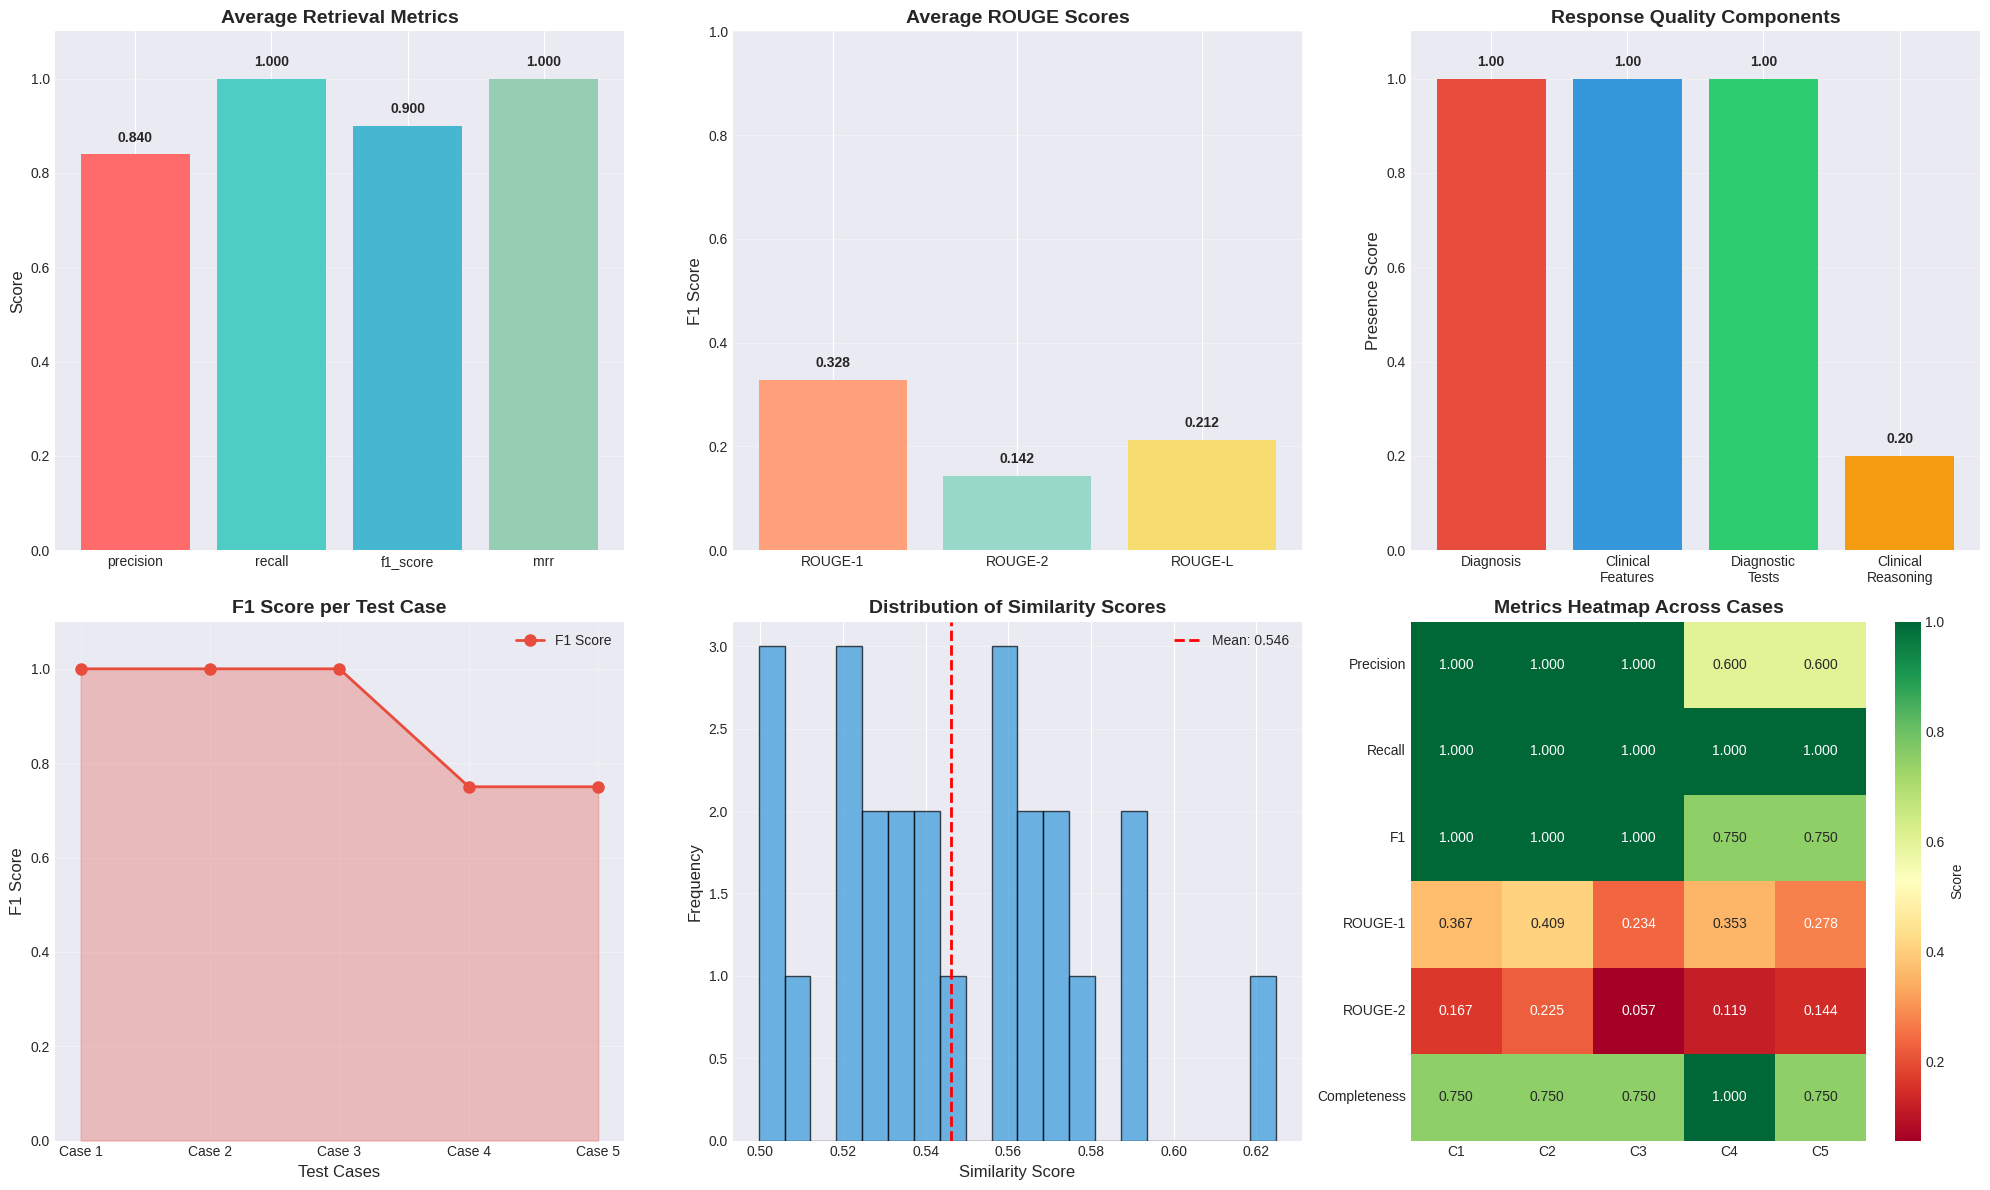

✅ Distribution plot saved as: rag_metrics_distribution.png


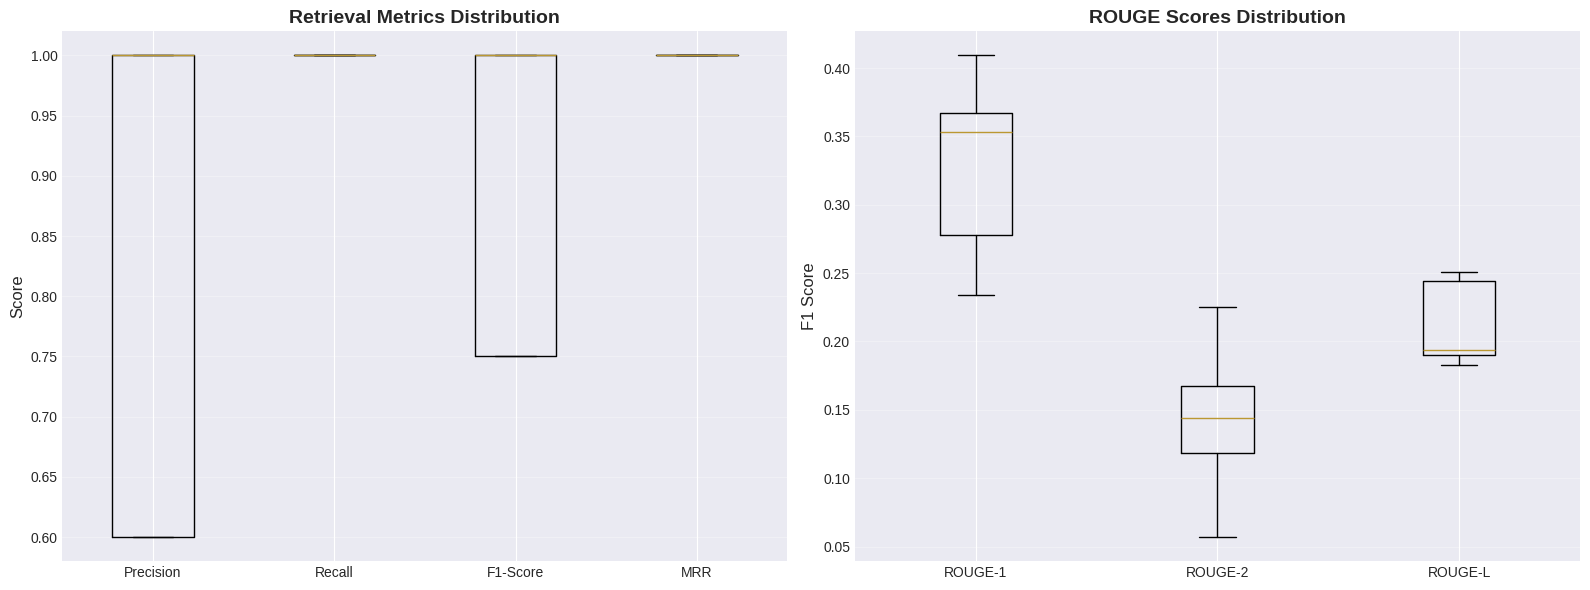

In [ ]:
# ============================================================================
# VISUALIZATION OF EVALUATION RESULTS
# ============================================================================

print("📊 Creating visualizations...")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Retrieval Metrics Comparison
ax1 = plt.subplot(2, 3, 1)
retrieval_metrics = ['precision', 'recall', 'f1_score', 'mrr']
retrieval_values = [eval_df[m].mean() for m in retrieval_metrics]
bars1 = ax1.bar(retrieval_metrics, retrieval_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Average Retrieval Metrics', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, retrieval_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. ROUGE Scores
ax2 = plt.subplot(2, 3, 2)
rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [eval_df[m].mean() for m in rouge_metrics]
bars2 = ax2.bar(rouge_labels, rouge_values, color=['#FFA07A', '#98D8C8', '#F7DC6F'])
ax2.set_title('Average ROUGE Scores', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_ylim(0, 1.0)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, rouge_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Response Quality Components
ax3 = plt.subplot(2, 3, 3)
quality_components = ['has_diagnosis', 'has_clinical_features', 'has_diagnostic_tests', 'has_clinical_reasoning']
quality_labels = ['Diagnosis', 'Clinical\nFeatures', 'Diagnostic\nTests', 'Clinical\nReasoning']
quality_values = [eval_df[m].mean() for m in quality_components]
bars3 = ax3.bar(quality_labels, quality_values, color=['#E74C3C', '#3498DB', '#2ECC71', '#F39C12'])
ax3.set_title('Response Quality Components', fontsize=14, fontweight='bold')
ax3.set_ylabel('Presence Score', fontsize=12)
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars3, quality_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Per-Case F1 Scores
ax4 = plt.subplot(2, 3, 4)
cases = [f"Case {i}" for i in range(1, len(eval_df) + 1)]
ax4.plot(cases, eval_df['f1_score'], marker='o', linewidth=2, markersize=8, color='#E74C3C', label='F1 Score')
ax4.fill_between(range(len(cases)), eval_df['f1_score'], alpha=0.3, color='#E74C3C')
ax4.set_title('F1 Score per Test Case', fontsize=14, fontweight='bold')
ax4.set_xlabel('Test Cases', fontsize=12)
ax4.set_ylabel('F1 Score', fontsize=12)
ax4.set_ylim(0, 1.1)
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5. Similarity Scores Distribution
ax5 = plt.subplot(2, 3, 5)
all_similarities = []
for case in evaluation_cases:
    result = generate_response(case['query'], top_k=5, verbose=False)
    all_similarities.extend([doc['similarity'] for doc in result['retrieved_documents']])

ax5.hist(all_similarities, bins=20, color='#3498DB', alpha=0.7, edgecolor='black')
ax5.axvline(np.mean(all_similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_similarities):.3f}')
ax5.set_title('Distribution of Similarity Scores', fontsize=14, fontweight='bold')
ax5.set_xlabel('Similarity Score', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Comprehensive Metrics Heatmap
ax6 = plt.subplot(2, 3, 6)
heatmap_data = eval_df[['precision', 'recall', 'f1_score', 'rouge1_f1', 'rouge2_f1', 'completeness_score']].T
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'Score'},
            yticklabels=['Precision', 'Recall', 'F1', 'ROUGE-1', 'ROUGE-2', 'Completeness'],
            xticklabels=[f'C{i}' for i in range(1, len(eval_df) + 1)], ax=ax6)
ax6.set_title('Metrics Heatmap Across Cases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('rag_evaluation_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as: rag_evaluation_results.png")
plt.show()

# Additional: Performance Summary Box Plot
fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for retrieval metrics
ax_box1 = axes[0]
retrieval_data = eval_df[['precision', 'recall', 'f1_score', 'mrr']]
ax_box1.boxplot([retrieval_data[col] for col in retrieval_data.columns],
                labels=['Precision', 'Recall', 'F1-Score', 'MRR'])
ax_box1.set_title('Retrieval Metrics Distribution', fontsize=14, fontweight='bold')
ax_box1.set_ylabel('Score', fontsize=12)
ax_box1.grid(axis='y', alpha=0.3)

# Box plot for ROUGE metrics
ax_box2 = axes[1]
rouge_data = eval_df[['rouge1_f1', 'rouge2_f1', 'rougeL_f1']]
ax_box2.boxplot([rouge_data[col] for col in rouge_data.columns],
                labels=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
ax_box2.set_title('ROUGE Scores Distribution', fontsize=14, fontweight='bold')
ax_box2.set_ylabel('F1 Score', fontsize=12)
ax_box2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rag_metrics_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Distribution plot saved as: rag_metrics_distribution.png")
plt.show()

In [ ]:
# ============================================================================
# SAVE ARTIFACTS FOR STREAMLIT DEPLOYMENT
# ============================================================================

print("💾 Saving artifacts for Streamlit deployment...")

# Create deployment directory
deploy_dir = Path("streamlit_app")
deploy_dir.mkdir(exist_ok=True)

print(f"   Created directory: {deploy_dir}")

# 1. Save configuration
config_dict = {
    'EMBEDDING_MODEL': config.EMBEDDING_MODEL,
    'LLM_MODEL': config.LLM_MODEL,
    'TOP_K_RETRIEVAL': config.TOP_K_RETRIEVAL,
    'MAX_NEW_TOKENS': config.MAX_NEW_TOKENS,
    'TEMPERATURE': config.TEMPERATURE,
    'TOP_P': config.TOP_P,
    'FAISS_INDEX_PATH': config.FAISS_INDEX_PATH,
    'METADATA_PATH': config.METADATA_PATH,
}

with open(deploy_dir / "config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)
print("   ✅ Saved: config.json")

# 2. Copy FAISS index and metadata
import shutil
shutil.copy(config.FAISS_INDEX_PATH, deploy_dir / config.FAISS_INDEX_PATH)
shutil.copy(config.METADATA_PATH, deploy_dir / config.METADATA_PATH)
print(f"   ✅ Saved: {config.FAISS_INDEX_PATH}")
print(f"   ✅ Saved: {config.METADATA_PATH}")

# 3. Save evaluation results
eval_df.to_csv(deploy_dir / "evaluation_results.csv", index=False)
print("   ✅ Saved: evaluation_results.csv")

# 4. Copy visualization images
if Path('rag_evaluation_results.png').exists():
    shutil.copy('rag_evaluation_results.png', deploy_dir / 'rag_evaluation_results.png')
    print("   ✅ Saved: rag_evaluation_results.png")

if Path('rag_metrics_distribution.png').exists():
    shutil.copy('rag_metrics_distribution.png', deploy_dir / 'rag_metrics_distribution.png')
    print("   ✅ Saved: rag_metrics_distribution.png")

print(f"\n✅ All artifacts saved to: {deploy_dir}")
print(f"\n📦 Deployment package contents:")
for item in sorted(deploy_dir.iterdir()):
    size = item.stat().st_size / (1024 * 1024)
    print(f"   - {item.name:.<50} {size:>8.2f} MB")

💾 Saving artifacts for Streamlit deployment...
   Created directory: streamlit_app
   ✅ Saved: config.json
   ✅ Saved: medical_rag_faiss.index
   ✅ Saved: medical_rag_metadata.json
   ✅ Saved: evaluation_results.csv

✅ All artifacts saved to: streamlit_app

📦 Deployment package contents:
   - config.json.......................................     0.00 MB
   - evaluation_results.csv............................     0.00 MB
   - medical_rag_faiss.index...........................     0.78 MB
   - medical_rag_metadata.json.........................     1.81 MB
